Code to process data for and plot Figure S3 from Siegfried\*, Venturelli\*, et al. (2023)

Email siegfried@mines.edu and venturelli@mines.edu with any questions

In [1]:
from pydicom import dcmread
import matplotlib.pyplot as plt
import seaborn as sns
import pygmt 
                 
import pandas as pd
import numpy as np
from glob import glob
import time
import random
import skimage.segmentation as seg
from scipy import optimize

skipped, no SliceLocation: 0
loaded: 34


<ipython-input-2-cd7ca6901595>:175: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


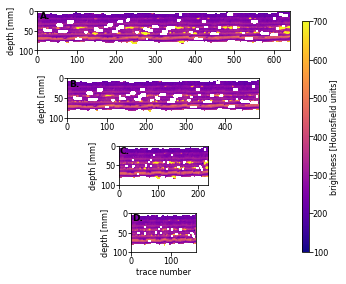

In [2]:
###### PLOT FIGURE S2 - ALL TRACES

# get the list of files for the core
files = glob('../data/cores/01UW-C/IM*')

# skip files with no SliceLocation information (should be a float)
slices = []
skipcount = 0
for f in files:
    ds = dcmread(f)
    if isinstance(ds.SliceLocation,float):
        slices.append(ds)
    else:
        skipcount = skipcount + 1

print("skipped, no SliceLocation: {}".format(skipcount))
print("loaded: {}".format(len(slices)))
# re-sort to put the slices in the right order
slices = sorted(slices, key=lambda s: s.SliceLocation)

# pixel dimensions, assuming all slices are the same
ps = slices[0].PixelSpacing
ss = slices[0].SliceThickness

# create 3D array
img_shape = list(slices[0].pixel_array.shape)
img_shape.append(len(slices))
img3d = np.zeros(img_shape)

# fill 3D array with the images from the files
for i, s in enumerate(slices):
    img2d = s.pixel_array
    img3d[:, :, i] = img2d
    
# Subset to get rid of most of the background -- indices determined by hand
core = np.copy(img3d[70:1500,670:871,:])

# get the shape of the images and make vectors for x (columns), y (rows), and z (slices).
shp = core.shape
yvals = np.arange(0,shp[0])*ps[0]
xvals = np.arange(0,shp[1])*ps[1]-np.mean(np.arange(0,shp[1])*ps[1])
zvals = np.arange(0,shp[2])*ss-np.mean(np.arange(0,shp[2])*ss)

# go through and do a quick unsupervised classification of the core that
# we will use as a mask to only look at laminated lake sediments
core_mask = np.empty(core.shape)
for i in np.arange(0,shp[2]):
    thisslice = core[:,:,i]
    mskd = seg.slic(thisslice, n_segments=3, start_label=0)
    core_mask[:,:,i] = mskd

# load traced tops of undeformed core -- these are indices relative to 70 mm that were hand picked
coretops = pd.read_csv('../data/cores/core_tops.csv')

# only use indices from -2 cm to +2.5 cm in x (edges are deformed)
minx = -20 # in mm
maxx = 25 # in mm
ix = np.where(np.logical_and(xvals>=minx, xvals<=maxx))[0]
xvals_subset = xvals[ix]

# sample core vertical for pixel brightness values
# limit to certain slices and certain location in the core to avoid deformed bits

# need a consistent area of laminated lake seds to find the right mask value; arbitrarily determined
miny_laminated = 100 # in mm
maxy_laminated = 120 # in mm
iy_laminated = np.where(np.logical_and(yvals>=miny_laminated, yvals<=maxy_laminated))[0]


# only use incides from slices at -11.0 mm to 3.0 mm determined as the
# undeformed slices by eye. 
min_slice = -13 # in mm
max_slice = -5 # in mm
iz = np.where(np.logical_and(zvals>=min_slice, zvals<=max_slice))[0]

# grab depth indices that we will extract
miny = 70 # in mm
maxy = 170 # in mm
iy = np.where(np.logical_and(yvals>=miny, yvals<=maxy))[0]
yvals_subset = yvals[iy]

traces_out = np.empty((len(yvals_subset),len(xvals_subset)*len(iz)))

# extract each slice of undeformed laminated sediments
for cnt,i in enumerate(iz):
    thisslice = np.copy(core[:,:,i])
    seds_nomsk = np.copy(thisslice)
    thistop = coretops.iloc[:,[cnt]]

    # mask the core slice
    msk = core_mask[:,:,i]
    msk_val = np.round(msk[iy_laminated,:][:,ix].mean())
    thisslice[msk!=msk_val] = np.nan
    thisslice[thisslice<0] = np.nan
    
    # subset to the lake sediments
    seds = thisslice[iy,:][:,ix]
    seds_nomsk = seds_nomsk[iy,:][:,ix]
    
    # go through each vertical trace and fill nans to the core top
    for j in np.arange(0,len(seds[0,:])):
        seds[0:int(thistop.iloc[j]),j] = np.nan
    
    traces_out[:,cnt*len(xvals_subset):(cnt+1)*len(xvals_subset)] = seds



thresh = 800 # brightness threshold for saying something is a clast
filt_limit = 0.02 # if a trace has more than this fraction of "bad" data, throw it out
climits = [100,700]

# calculate number of values between top and bottom of lake sediments
shp = traces_out.shape
num_values=np.empty(shp[1])

# find the last NaN on top and the first NaN on bottom, then calculate the number of indices in-between
for i in np.arange(0,shp[1]):
    thistrace = traces_out[:,i]
    idx_start = np.argmin(np.isnan(thistrace))
    idx_end = len(thistrace)-np.argmin(np.isnan(np.flip(thistrace)))
    num_values[i] = idx_end - idx_start
    
# use our clast brightness threshold to filter
clasts=traces_out>thresh
no_clasts = np.sum(clasts,axis=0)/num_values < filt_limit

# we already replaced all negative brightness with nan, so now we just count them up
no_voids = np.sum(~np.isnan(traces_out), axis=0)/num_values > 1 - filt_limit

with plt.rc_context({"axes.labelsize": 8, 
                     "xtick.labelsize": 8, "ytick.labelsize": 8,
                     'xtick.major.pad': 1, 'ytick.major.pad': 0, 
                     'axes.labelpad': 2}):
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(4.75,4), facecolor='white')
    ax1.imshow(traces_out, 
               clim=(climits), cmap='plasma',
               extent=[0,len(traces_out[0,:]),max(yvals_subset)-yvals_subset[0],
                       min(yvals_subset)-yvals_subset[0]])
    ax1.set_ylabel('depth [mm]')
    ax1.set_yticks([0,50,100])

    ax2.imshow(traces_out[:,no_clasts], 
               clim=(climits), cmap='plasma',
               extent=[0,len(traces_out[0,no_clasts]),max(yvals_subset)-yvals_subset[0],min(yvals_subset)-yvals_subset[0]])
    ax2.set_ylabel('depth [mm]')
    ax2.set_yticks([0,50,100])
    
    ax3.imshow(traces_out[:,no_voids], 
               clim=(climits), cmap='plasma',
               extent=[0,len(traces_out[0,no_voids]),max(yvals_subset)-yvals_subset[0],min(yvals_subset)-yvals_subset[0]])
    ax3.set_ylabel('depth [mm]')
    ax3.set_yticks([0,50,100])
    ax3.set_xticks([0,100,200])
    
    im = ax4.imshow(traces_out[:,np.logical_and(no_clasts,no_voids)], 
               clim=(climits), cmap='plasma',
               extent=[0,len(traces_out[0,np.logical_and(no_clasts,no_voids)]),
                       max(yvals_subset)-yvals_subset[0],min(yvals_subset)-yvals_subset[0]])
    ax4.set_xlabel('trace number')
    ax4.set_ylabel('depth [mm]')
    ax4.set_yticks([0,50,100])
    
    ax1.annotate(xy=(0.01,0.98),text = 'A.', xycoords = 'axes fraction', 
                 va = 'top', fontsize = 9, fontweight = 'bold')
    ax2.annotate(xy=(0.01,0.98),text = 'B.', xycoords = 'axes fraction', 
                 va = 'top', fontsize = 9, fontweight = 'bold')
    ax3.annotate(xy=(0.01,0.98),text = 'C.', xycoords = 'axes fraction', 
                 va = 'top', fontsize = 9, fontweight = 'bold')
    ax4.annotate(xy=(0.01,0.98),text = 'D.', xycoords = 'axes fraction', 
                 va = 'top', fontsize = 9, fontweight = 'bold')

    cbar_ax = fig.add_axes([0.95, 0.125, 0.02, 0.8])
    fig.colorbar(im, cax=cbar_ax, label = 'brightness [Hounsfield units]')

fig.tight_layout()
plt.savefig('siegvent2023-figS3.png', 
            bbox_inches='tight', transparent = False, dpi = 300)
plt.show()